In [1]:
import argparse
import wandb
import copy
from tqdm import tqdm
from statistics import mean, stdev
from sklearn import metrics

import torch

import PIL

from inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import open_clip
from optim_utils import *
from io_utils import *

from IPython.display import display

In [2]:
parser = argparse.ArgumentParser(description='tree-ring_inversion_experiment')
parser.add_argument('--run_name', default='tree-ring_inversion_experiment')
parser.add_argument('--dataset', default='Gustavosta/Stable-Diffusion-Prompts')
parser.add_argument('--start', default=0, type=int)
parser.add_argument('--end', default=1, type=int)
parser.add_argument('--image_length', default=512, type=int)
parser.add_argument('--model_id', default='stabilityai/stable-diffusion-2-1-base')
parser.add_argument('--with_tracking', action='store_false', default=True)
parser.add_argument('--num_images', default=1, type=int)
parser.add_argument('--guidance_scale', default=7.5, type=float)
parser.add_argument('--num_inference_steps', default=50, type=int)
parser.add_argument('--test_num_inference_steps', default=None, type=int)
parser.add_argument('--reference_model', default='ViT-g-14')
parser.add_argument('--reference_model_pretrain', default='laion2b_s12b_b42k')
parser.add_argument('--max_num_log_image', default=100, type=int)
parser.add_argument('--gen_seed', default=0, type=int)

# watermark
parser.add_argument('--w_seed', default=999999, type=int)
parser.add_argument('--w_channel', default=3, type=int)
parser.add_argument('--w_pattern', default='ring')
parser.add_argument('--w_mask_shape', default='circle')
parser.add_argument('--w_radius', default=10, type=int)
parser.add_argument('--w_measurement', default='l1_complex')
parser.add_argument('--w_injection', default='complex')
parser.add_argument('--w_pattern_const', default=0, type=float)

# for image distortion
parser.add_argument('--r_degree', default=75, type=float)
parser.add_argument('--jpeg_ratio', default=None, type=int)
parser.add_argument('--crop_scale', default=None, type=float)
parser.add_argument('--crop_ratio', default=None, type=float)
parser.add_argument('--gaussian_blur_r', default=None, type=int)
parser.add_argument('--gaussian_std', default=None, type=float)
parser.add_argument('--brightness_factor', default=None, type=float)
parser.add_argument('--rand_aug', default=0, type=int)

args, unknown = parser.parse_known_args()

if args.test_num_inference_steps is None:
    args.test_num_inference_steps = args.num_inference_steps

# LOAD Model+Data

In [3]:
# load diffusion model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE={device}')

scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_id, subfolder='scheduler')

# original pipe (used for generating images and also inversion)
print('LOAD PIPE Original')
pipe = InversableStableDiffusionPipeline.from_pretrained(
    args.model_id,
    scheduler=scheduler,
    #torch_dtype=torch.float16,
    torch_dtype=torch.float32,
    revision='fp16',
    )
pipe = pipe.to(device)

# alternative pipe (used for inversion process only)
print('LOAD PIPE 0')
pipe_0 = InversableStableDiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    scheduler=scheduler,
    #torch_dtype=torch.float16,
    torch_dtype=torch.float32,
    revision='fp16',
    )
pipe_0 = pipe_0.to(device)

# dataset
dataset, prompt_key = get_dataset(args)

# ground-truth patch
gt_patch = get_watermarking_pattern(pipe, args, device)

results = []
clip_scores = []
clip_scores_w = []
no_w_metrics = []
w_metrics = []

DEVICE=cuda


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

# RUN Settings

In [4]:
current_prompt = dataset[0][prompt_key]

known_prompt = current_prompt # assume at the detection time, the original prompt is unknown
known_text_embeddings = pipe.get_text_embedding(known_prompt)

unknown_prompt = '' # assume at the detection time, the original prompt is unknown
unknown_text_embeddings = pipe.get_text_embedding(unknown_prompt)

seed = args.gen_seed

# GENERATE

## GENERATE WO Watermark

In [6]:
### generation
# generation without watermarking
set_random_seed(seed)
init_latents_no_w = pipe.get_random_latents()
outputs_no_w = pipe(
    current_prompt,
    num_images_per_prompt=args.num_images,
    guidance_scale=args.guidance_scale,
    num_inference_steps=args.num_inference_steps,
    height=args.image_length,
    width=args.image_length,
    latents=init_latents_no_w,
    )
gen_no_w = outputs_no_w.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

## GENERATE W Watermark

In [7]:
# generation with watermarking
if init_latents_no_w is None:
    set_random_seed(seed)
    init_latents_w = pipe.get_random_latents()
else:
    init_latents_w = copy.deepcopy(init_latents_no_w)

# get watermarking mask
watermarking_mask = get_watermarking_mask(init_latents_w, args, device)

# inject watermark
init_latents_w, init_latens_w_fft = inject_watermark(init_latents_w, watermarking_mask, gt_patch, args,
                                                     # and-mill -------------------------------------------
                                                     return_fft=True
                                                     # and-mill -------------------------------------------
                                                     )

outputs_w = pipe(
    current_prompt,
    num_images_per_prompt=args.num_images,
    guidance_scale=args.guidance_scale,
    num_inference_steps=args.num_inference_steps,
    height=args.image_length,
    width=args.image_length,
    latents=init_latents_w,
    )
gen_w = outputs_w.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
# remember fft of the watermark
gen_w_initial_wchannel = init_latens_w_fft[0][args.w_channel].real.detach().cpu().numpy()

# APPLY Distortion

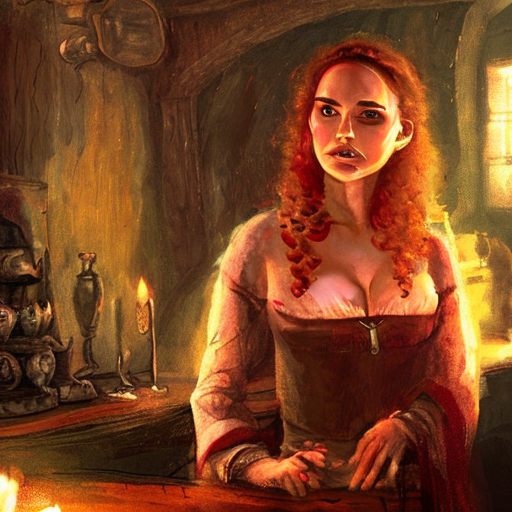

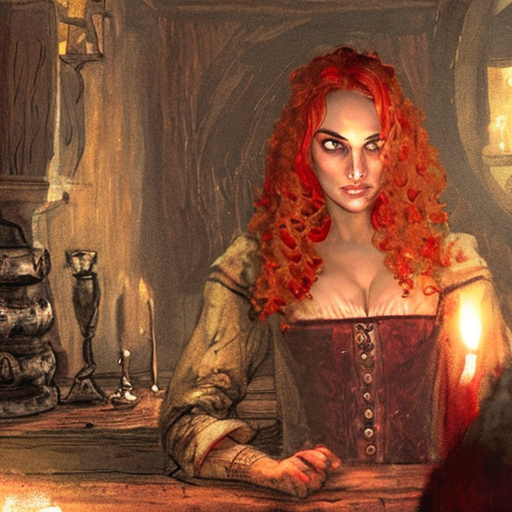

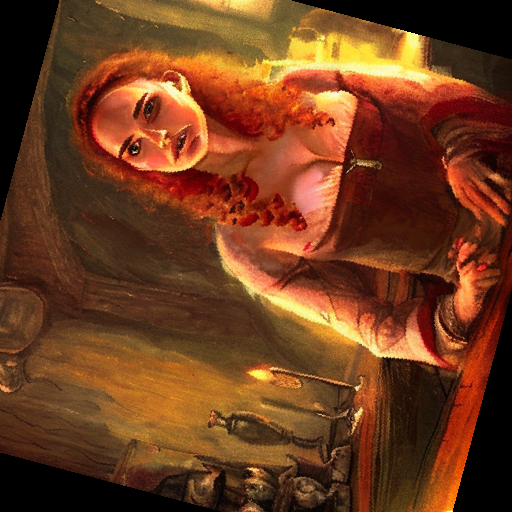

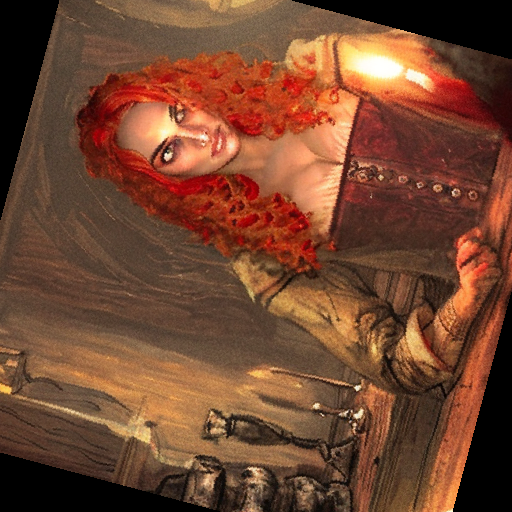

In [9]:
### test watermark
# distortion
gen_no_w_distorted, gen_w_distorted = image_distortion(gen_no_w, gen_w, seed+1, args)

display(gen_no_w)
display(gen_w)
display(gen_no_w_distorted)
display(gen_w_distorted)

# INVERSION

In [10]:
# for defining order of cells in wandb
COLUMNS = ['prompt',
           'BASE=gen_no_w',
           'FFT(wchannel)   BASE=gen_no_w   PIPE=orig   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_no_w   PIPE=orig   TEXT=unknown_text_embedding',
           'FFT(wchannel)   BASE=gen_no_w   PIPE=alt0   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_no_w   PIPE=alt0   TEXT=unknown_text_embedding',
           'BASE=gen_no_w_distorted',
           'FFT(wchannel)   BASE=gen_no_w_distorted   PIPE=orig   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_no_w_distorted   PIPE=orig   TEXT=unknown_text_embedding',
           'FFT(wchannel)   BASE=gen_no_w_distorted   PIPE=alt0   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_no_w_distorted   PIPE=alt0   TEXT=unknown_text_embedding',
           'BASE=gen_w',
           'FFT(wchannel)   BASE=gen_w   PIPE=orig   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_w   PIPE=orig   TEXT=unknown_text_embedding',
           'FFT(wchannel)   BASE=gen_w   PIPE=alt0   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_w   PIPE=alt0   TEXT=unknown_text_embedding',
           'BASE=gen_w_distorted',
           'FFT(wchannel)   BASE=gen_w_distorted   PIPE=orig   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_w_distorted   PIPE=orig   TEXT=unknown_text_embedding',
           'FFT(wchannel)   BASE=gen_w_distorted   PIPE=alt0   TEXT=known_text_embedding',
           'FFT(wchannel)   BASE=gen_w_distorted   PIPE=alt0   TEXT=unknown_text_embedding']

# these are axis to iterate over during analysis
BASES = {'gen_no_w': gen_no_w,
         'gen_no_w_distorted': gen_no_w_distorted,
         'gen_w': gen_w,
         'gen_w_distorted': gen_w_distorted}
PIPES = {'orig': pipe}#, 'alt0': pipe_0}
TEXTS = {'known_text_embedding': known_text_embeddings,
         'unknown_text_embedding': unknown_text_embeddings}

# start collecting the row cells
row = {'prompt': current_prompt,
       'BASE=gen_no_w': gen_no_w,
       'BASE=gen_no_w_distorted': gen_no_w_distorted,
       'BASE=gen_w': gen_w,
       'BASE=gen_w_distorted': gen_w_distorted,
       }

In [11]:
# base images (w/wo watermark x distorted)
for img_key, img in BASES.items():
    # pipes
    for pipe_key, pipe in PIPES.items():
        # text embedding
        for text_key, text_embedding in TEXTS.items():
        
            # get latent
            latents = pipe.get_image_latents(transform_img(img).unsqueeze(0).to(text_embedding.dtype).to(device),
                                             sample=False)
            # revert latents back to init
            extracted_init = pipe.forward_diffusion(
                latents=latents,
                text_embeddings=text_embedding,
                guidance_scale=1,
                num_inference_steps=args.test_num_inference_steps,
            )
            # fft
            extracted_init_fft_wchannel = torch.fft.fftshift(torch.fft.fft2(extracted_init), dim=(-1, -2))[0][args.w_channel].real.detach().cpu().numpy()
            # add to row
            row[f'FFT(wchannel)   BASE={img_key}   PIPE={pipe_key}   TEXT={text_key}'] = extracted_init_fft_wchannel

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

# SAVE WANDB

In [11]:
if args.with_tracking:

    def wandb_type(cell):
        """Helper funktion to convert data to wandb compatible format"""
        if isinstance(cell, torch.Tensor) or isinstance(cell, np.ndarray) or isinstance(cell, PIL.Image.Image):
            return wandb.Image(cell)
        elif isinstance(cell, str):
            return cell
        else:
            raise Exception(f'Unknown type: {type(cell)}')

    wandb.init(project='tree-ring_inversion_experiment')
    wandb.config.update(args)
    
    # start table
    columns = [c for c in COLUMNS if c in row.keys()]  # only columns we actually collected
    table = wandb.Table(columns=columns)
    table.add_data(*[wandb_type(row[col]) for col in table.columns if col in row.keys()])

    wandb.log({'table': table})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: and-mill. Use `wandb login --relogin` to force relogin
